In [1]:
# !pip install python_environment_check

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
# from python_environment_check import check_packages


# d = {
#     'numpy': '1.21.2',
#     'matplotlib': '3.4.3',
#     'sklearn': '1.0',
# }
# check_packages(d)

In [4]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [5]:
X = ((X / 255.) - .5) * 2

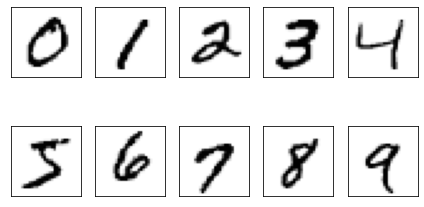

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

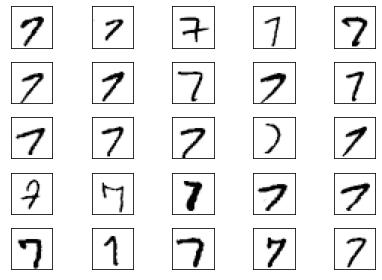

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp

In [9]:
import numpy as np

In [10]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden_1
        rng = np.random.RandomState(random_seed)
        
        self.weight_h_1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden_1, num_features))
        self.bias_h_1 = np.zeros(num_hidden_1)

        #hidden_2
        self.weight_h_2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden_2, num_hidden_1))
        self.bias_h_2 = np.zeros(num_hidden_2)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden_2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer 1
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h_1 = np.dot(x, self.weight_h_1.T) + self.bias_h_1
        a_h_1 = sigmoid(z_h_1)

        #hidden layer 2
        z_h_2 = np.dot(a_h_1, self.weight_h_2.T) + self.bias_h_2
        a_h_2 = sigmoid(z_h_2)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h_2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h_1, a_h_2, a_out

    def backward(self, x, a_h_1, a_h_2, a_out, y):  #TODO
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]         

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h_2
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHidden2Weights
        ## = DeltaOut * dOutNet/dHidden2Act * dHidden2Act/dHidden2Net * dHidden2Net/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h_2 = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h_2 = np.dot(delta_out, d_z_out__a_h_2)
        
        # [n_examples, n_hidden]
        d_a_h_2__d_z_h_2 = a_h_2 * (1. - a_h_2) # sigmoid derivative

        delta_h_2 = d_loss__a_h_2 * d_a_h_2__d_z_h_2 # "delta (rule) placeholder"
        
        # [n_examples, n_features]
        d_z_h_2__d_w_h_2 = a_h_1
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h_2 = np.dot((d_loss__a_h_2 * d_a_h_2__d_z_h_2).T, d_z_h_2__d_w_h_2)
        d_loss__d_b_h_2 = np.sum((d_loss__a_h_2 * d_a_h_2__d_z_h_2), axis=0)
        
        
        #################################        
        # Part 3: dLoss/dHidden1Weights
        
        # [n_classes, n_hidden]
        d_z_out__a_h_1 = self.weight_h_2
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h_1 = np.dot(delta_h_2, d_z_out__a_h_1)
        
        # [n_examples, n_hidden]
        d_a_h_1__d_z_h_1 = a_h_1 * (1. - a_h_1) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h_1__d_w_h_1 = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h_1 = np.dot((d_loss__a_h_1 * d_a_h_1__d_z_h_1).T, d_z_h_1__d_w_h_1)
        d_loss__d_b_h_1 = np.sum((d_loss__a_h_1 * d_a_h_1__d_z_h_1), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h_2, d_loss__d_b_h_2, 
                d_loss__d_w_h_1, d_loss__d_b_h_1)

In [11]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden_1=50,
                     num_hidden_2 = 50,
                     num_classes=10)

In [12]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [13]:


def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_,_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')



Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


In [14]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _,_, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [15]:


mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')



Initial valid MSE: 0.3
Initial valid accuracy: 9.0%


In [16]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h_1, a_h_2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h_2, d_loss__d_b_h_2 , \
            d_loss__d_w_h_1, d_loss__d_b_h_1 = \
                model.backward(X_train_mini, a_h_1, a_h_2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h_1 -= learning_rate * d_loss__d_w_h_1
            model.bias_h_1 -= learning_rate * d_loss__d_b_h_1
            model.weight_h_2 -= learning_rate * d_loss__d_w_h_2
            model.bias_h_2 -= learning_rate * d_loss__d_b_h_2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [17]:
# np.random.seed(123) # for the training set shuffling

# epoch_loss, epoch_train_acc, epoch_valid_acc = train(
#     model, X_train, y_train, X_valid, y_valid,
#     num_epochs=50, learning_rate=0.1)

In [18]:
# plt.plot(range(len(epoch_loss)), epoch_loss)
# plt.ylabel('Mean squared error')
# plt.xlabel('Epoch')
# #plt.savefig('figures/11_07.png', dpi=300)
# plt.show()

In [19]:


# plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
#          label='Training')
# plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
#          label='Validation')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend(loc='lower right')
# #plt.savefig('figures/11_08.png', dpi=300)
# plt.show()



In [20]:


# test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
# print(f'Test accuracy: {test_acc*100:.2f}%')



In [21]:
# X_test_subset = X_test[:1000, :]
# y_test_subset = y_test[:1000]

# _,_, probas = model.forward(X_test_subset)
# test_pred = np.argmax(probas, axis=1)

# misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
# misclassified_labels = test_pred[y_test_subset != test_pred][:25]
# correct_labels = y_test_subset[y_test_subset != test_pred][:25]

In [22]:
# fig, ax = plt.subplots(nrows=5, ncols=5, 
#                        sharex=True, sharey=True, figsize=(8, 8))
# ax = ax.flatten()
# for i in range(25):
#     img = misclassified_images[i].reshape(28, 28)
#     ax[i].imshow(img, cmap='Greys', interpolation='nearest')
#     ax[i].set_title(f'{i+1}) '
#                     f'True: {correct_labels[i]}\n'
#                     f' Predicted: {misclassified_labels[i]}')

# ax[0].set_xticks([])
# ax[0].set_yticks([])
# plt.tight_layout()
# #plt.savefig('figures/11_09.png', dpi=300)
# plt.show()

Prediction Performance

In [23]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X,y,test_size= 0.3, random_state=123, stratify=y)

my_model = NeuralNetMLP(num_features=28*28,
                     num_hidden_1=50,
                     num_hidden_2 = 50,
                     num_classes=10)

In [24]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    my_model, train_X, train_y, val_X, val_y,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 21.29% | Valid Acc: 21.53%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 23.40% | Valid Acc: 23.33%
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 33.60% | Valid Acc: 33.36%
Epoch: 004/050 | Train MSE: 0.06 | Train Acc: 59.08% | Valid Acc: 58.91%
Epoch: 005/050 | Train MSE: 0.05 | Train Acc: 66.51% | Valid Acc: 66.46%
Epoch: 006/050 | Train MSE: 0.04 | Train Acc: 77.70% | Valid Acc: 77.58%
Epoch: 007/050 | Train MSE: 0.03 | Train Acc: 83.58% | Valid Acc: 83.26%
Epoch: 008/050 | Train MSE: 0.03 | Train Acc: 86.68% | Valid Acc: 86.39%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 87.80% | Valid Acc: 87.67%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 88.56% | Valid Acc: 88.29%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 89.33% | Valid Acc: 88.99%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 89.81% | Valid Acc: 89.48%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 90.14% | Valid Acc: 89.74%
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 90.57

In [25]:
def predict(nnet, pred):
  _,_, probas = nnet.forward(pred)
  predicted_labels = np.argmax(probas, axis=1)
  return predicted_labels
def pred_prob(nnet, pred):
  _,_, probas = nnet.forward(pred)
  return probas


In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


pred_y = predict(my_model, val_X)

ary_pred = np.zeros((pred_y.shape[0], 10))
for i, val in enumerate(pred_y):
    ary_pred[i, val] = 1

ary_true = np.zeros((val_y.shape[0], 10))
for i, val in enumerate(val_y):
    ary_true[i, val] = 1

r_a_s = roc_auc_score(ary_true, ary_pred, multi_class='ovr')
print(r_a_s)


0.9701508433603288
